# **Modeling**

In [2]:
# Import relevant libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load in csv file with encoded data for later use
df_scaled = pd.read_csv('../data/healthcare-dataset-stroke-data-scaled.csv')

# Verify data
df_scaled.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,-1.298312,1.051434,-0.328602,4.185032,2.706375,1.005086,1.189990,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,0.984080,2.184951,-0.766774,-0.427313,1
1,0.716371,0.786070,-0.328602,-0.238947,2.121559,-0.098981,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,-1.016178,-0.457676,1.304165,-0.427313,1
2,-0.255478,1.626390,-0.328602,4.185032,-0.005028,0.472536,1.189990,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,-1.016178,-0.457676,1.304165,-0.427313,1
3,1.118363,0.255342,-0.328602,-0.238947,1.437358,0.719327,-0.840343,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,0.984080,-0.457676,-0.766774,2.340204,1
4,-1.647136,1.582163,3.043196,-0.238947,1.501184,-0.631531,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,-1.016178,-0.457676,1.304165,-0.427313,1


In [4]:
# Setting random seed to make data reproducible
random_seed_number = 10
np.random.seed(random_seed_number)

In [5]:
# Loading train and test variables into notebook
%store -r

In [6]:
# Verifying train and test variables are present
def func(var):
    if var in globals():
        return True

print(func('X_train'))
print(func('X_test'))
print(func('y_train'))
print(func('y_test'))

True
True
True
True


## *Initial Model*

In [8]:
# Creating an out of the box model
lr = LogisticRegression(random_state=random_seed_number)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
model_accuracy  = accuracy_score(y_test, y_pred)

print("The Accuracy of simple logistic regression without hyperparmeters:",model_accuracy)
print("\n")
print(classification_report(y_test, y_pred))

The Accuracy of simple logistic regression without hyperparmeters: 0.9383561643835616


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



Accuracy is high, but this does not seem to be a good model. 
Accuracy is high becuase there is a known class imbalance. 
The model predicted a stroke event not occuring in all the data except one instance. 

In [10]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([1021,    1], dtype=int64))

In [11]:
# Creating a balanced class model
lr_bal = LogisticRegression(class_weight='balanced', random_state=random_seed_number)
lr_bal.fit(X_train,y_train)

y_pred = lr_bal.predict(X_test)
model_accuracy  = accuracy_score(y_test, y_pred)

print("The Accuracy of simple logistic regression with class weight parameter:",model_accuracy)
print("\n")
print(classification_report(y_test, y_pred))

The Accuracy of simple logistic regression with class weight parameter: 0.7583170254403131


              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.57      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022



Accuracy decreased significantly, but improvements are seen in the precision and recall metrics. 
Let's do some more hyperparameter tuning using this balanced class model. 

Some penalties are not compatiable with some solvers so three different models will be created.

## *Hyperparameter Tuning with GridSearchCV*

In [15]:
# Model 1
param_grid = [
    {'penalty':['l2',None],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','sag'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_cv1 = GridSearchCV(lr_bal,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1, error_score='raise')

In [16]:
# Model 2
param_grid = [
    {'penalty':['l1','l2'],
    'C' : np.logspace(-4,4,20),
    'solver': ['liblinear'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_cv2 = GridSearchCV(lr_bal,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1, error_score='raise')

In [17]:
# Model 3
param_grid = [
    {'penalty':['l1','l2','elasticnet',None],
    'C' : np.logspace(-4,4,20),
    'solver': ['saga'],
    'max_iter': [100,1000,2500,5000],
    'l1_ratio': [0.10, 0.25, 0.5, 0.75, 0.9]
}
]
lr_cv3 = GridSearchCV(lr_bal,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1, error_score='raise')

In [18]:
# Fitting each model on train data
lr_cv1.fit(X_train,y_train)
lr_cv2.fit(X_train,y_train)
lr_cv3.fit(X_train,y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Fitting 3 folds for each of 160 candidates, totalling 480 fits
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=10),
             n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet', None],
                          'solver': ['saga']}],
             verbose=True)

In [19]:
# Finding optimal parameters
print(lr_cv1.best_params_) 
print(lr_cv2.best_params_)
print(lr_cv3.best_params_)

{'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
{'C': 0.0001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
{'C': 0.0001, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': None, 'solver': 'saga'}


In [20]:
# Printing accuracy of each model
print(f'Accuracy of model 1- : {lr_cv1.score(X_test,y_test):.5f}')
print(f'Accuracy of model 2- : {lr_cv2.score(X_test,y_test):.5f}')
print(f'Accuracy of model 3- : {lr_cv3.score(X_test,y_test):.5f}')

Accuracy of model 1- : 0.74168
Accuracy of model 2- : 0.93933
Accuracy of model 3- : 0.75832


In [21]:
# Predicting with test data
y_pred1 = lr_cv1.predict(X_test)
y_pred2 = lr_cv2.predict(X_test)
y_pred3 = lr_cv3.predict(X_test)

# Printing classification report for each model
print("*************************Model 1*************************")
print(classification_report(y_test, y_pred1))

print("*************************Model 2*************************")
print(classification_report(y_test, y_pred2))

print("*************************Model 3*************************")
print(classification_report(y_test, y_pred3))

*************************Model 1*************************
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.16      0.77      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.74      0.81      1022

*************************Model 2*************************
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022

*************************Model 3*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.76      0.28        62

    accu

Model 2 gives similar results to the initial logistic regression model with default parameters (precision and recall are zero for the 1 class). 
Model 1 and 3 give identical results seen before hyperparameter tuning. 
Let's try using Random Grid Search to see if we get similar results through a less computationally expensive process.

## *Hyperparameter Tuning with RandomizedSearchCV*

In [24]:
# Model 1
param_grid = [
    {'penalty':['l2',None],
    'C' : uniform(0, 4),
    'solver': ['lbfgs','newton-cg','sag'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_rcv1 = RandomizedSearchCV(lr_bal,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise')

In [25]:
# Model 2
param_grid = [
    {'penalty':['l1','l2'],
    'C' : uniform(0, 4),
    'solver': ['liblinear'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_rcv2 = RandomizedSearchCV(lr_bal,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise')

In [26]:
# Model 3
param_grid = [
    {'penalty':['l1','l2','elasticnet',None],
    'C' : uniform(0, 4),
    'solver': ['saga'],
    'max_iter': [100,1000,2500,5000],
    'l1_ratio': uniform(0, 1)
}
]
lr_rcv3 = RandomizedSearchCV(lr_bal,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise')

In [27]:
# Fitting each model on train data
lr_rcv1.fit(X_train,y_train)
lr_rcv2.fit(X_train,y_train)
lr_rcv3.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=10),
                   n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A0302D8910>,
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A0357F5E10>,
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     None],
                                         'solver': ['saga']}],
                   verbose=True)

In [28]:
# Finding optimal parameters
print(lr_rcv1.best_params_) 
print(lr_rcv2.best_params_)
print(lr_rcv3.best_params_)

{'C': 0.8991865821233906, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
{'C': 2.4041558136181775, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'liblinear'}
{'C': 1.0054965368282374, 'l1_ratio': 0.5973716482308843, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}


In [29]:
# Printing accuracy of each model
print(f'Accuracy of model 1- : {lr_rcv1.score(X_test,y_test):.5f}')
print(f'Accuracy of model 2- : {lr_rcv2.score(X_test,y_test):.5f}')
print(f'Accuracy of model 3- : {lr_rcv3.score(X_test,y_test):.5f}')

Accuracy of model 1- : 0.75832
Accuracy of model 2- : 0.75832
Accuracy of model 3- : 0.75832


In [30]:
# Predicting with test data
y_pred1 = lr_rcv1.predict(X_test)
y_pred2 = lr_rcv2.predict(X_test)
y_pred3 = lr_rcv3.predict(X_test)

# Printing classification report for each model
print("*************************Model 1*************************")
print(classification_report(y_test, y_pred1))

print("*************************Model 2*************************")
print(classification_report(y_test, y_pred2))

print("*************************Model 3*************************")
print(classification_report(y_test, y_pred3))

*************************Model 1*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.57      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022

*************************Model 2*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.57      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022

*************************Model 3*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.76      0.28        62

    accu

All three models did not produce significant improvements. Given the fact that similar results are seen through a less exhaustive process, RandomizedSearchCV will be used going forward.

## *Verifying Results using Over-sampling Method*

We will perform over-sampling to the minority class to confirm the above algorithms executed correctly. 

(Under-sampling seems unnecessary since we have a low number of instances in the minority class).

In [35]:
# Creating SMOTE object
smote = SMOTE(sampling_strategy='minority', random_state=random_seed_number)

# Fitting on train data and resampling 
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [36]:
# Fitting original logistic regression model (without class_weight parameter) on new data
lr.fit(X_resampled,y_resampled)

y_pred = lr.predict(X_test)
model_accuracy  = accuracy_score(y_test, y_pred)

print("The Accuracy of simple logistic regression with over-sampled data:",model_accuracy)
print("\n")
print(classification_report(y_test, y_pred))

The Accuracy of simple logistic regression with over-sampled data: 0.761252446183953


              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022



A little bit better accuracy than with the 'class_weight' parameter set to balanced (76.125 vs 75.832). 
Similar classification report though. 
Let's rerun hyperparameter tuning using RandomizedSearchCV.

## *Hyperparameter Tuning with Over-sampled Data*

In [39]:
# Model 1
param_grid = [
    {'penalty':['l2',None],
    'C' : uniform(0, 4),
    'solver': ['lbfgs','newton-cg','sag'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_rcv1 = RandomizedSearchCV(lr,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise') #lr instead of lr_bal

In [40]:
# Model 2
param_grid = [
    {'penalty':['l1','l2'],
    'C' : uniform(0, 4),
    'solver': ['liblinear'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_rcv2 = RandomizedSearchCV(lr,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise') #lr instead of lr_bal

In [41]:
# Model 3
param_grid = [
    {'penalty':['l1','l2','elasticnet',None],
    'C' : uniform(0, 4),
    'solver': ['saga'],
    'max_iter': [100,1000,2500,5000],
    'l1_ratio': uniform(0, 1)
}
]
lr_rcv3 = RandomizedSearchCV(lr,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise') #lr instead of lr_bal

In [42]:
# Fitting each model on resampled data
lr_rcv1.fit(X_resampled,y_resampled)
lr_rcv2.fit(X_resampled,y_resampled)
lr_rcv3.fit(X_resampled,y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LogisticRegression(random_state=10), n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A030295250>,
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A030291A50>,
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     None],
                                         'solver': ['saga']}],
                   verbose=True)

In [43]:
# Finding optimal parameters
print(lr_rcv1.best_params_) 
print(lr_rcv2.best_params_)
print(lr_rcv3.best_params_)

{'C': 3.052962348574724, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
{'C': 2.3794437992332496, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
{'C': 0.7449910969918889, 'l1_ratio': 0.41379780649844733, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


In [44]:
# Printing accuracy of each model
print(f'Accuracy of model 1- : {lr_rcv1.score(X_test,y_test):.5f}')
print(f'Accuracy of model 2- : {lr_rcv2.score(X_test,y_test):.5f}')
print(f'Accuracy of model 3- : {lr_rcv3.score(X_test,y_test):.5f}')

Accuracy of model 1- : 0.76125
Accuracy of model 2- : 0.76125
Accuracy of model 3- : 0.76125


In [45]:
# Predicting with test data
y_pred1 = lr_rcv1.predict(X_test)
y_pred2 = lr_rcv2.predict(X_test)
y_pred3 = lr_rcv3.predict(X_test)

# Printing classification report for each model
print("*************************Model 1*************************")
print(classification_report(y_test, y_pred1))

print("*************************Model 2*************************")
print(classification_report(y_test, y_pred2))

print("*************************Model 3*************************")
print(classification_report(y_test, y_pred3))

*************************Model 1*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022

*************************Model 2*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022

*************************Model 3*************************
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.17      0.76      0.28        62

    accu

No hyperparameter tuning yielded improvements. 
These results seem to confirm that our previous algorithms setting the 'weight_class' to balanced performed as expected. 
Other models need to be tested.

But before possibly going through a similar process with other models, let's do some dimensionality reduction.

## *Principal Component Analysis (PCA)*

We will determine which principal components in our dataset account for a good portion of the variance, looking to make improvements in algorithm performance by fitting on data with less noise.

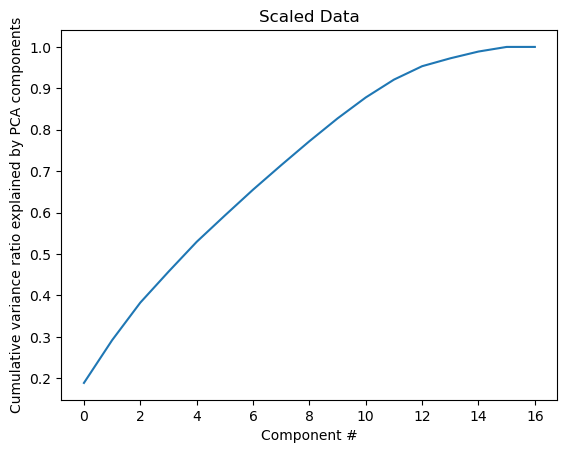

In [50]:
# Initialize a PCA model with a default number of components
pca = PCA()

# Fitting first on original scaled data
pca.fit(X_train)

# Extracting explained variance ratio
variance = pca.explained_variance_ratio_.cumsum()

# Plotting results
plt.plot(range(len(variance)), variance)

# Label the title and axes
plt.title("Scaled Data")
plt.xlabel("Component #")
plt.ylabel("Cumulative variance ratio explained by PCA components");

The first seven components account for over 70% of the variance seen in the dataset. Let's build a model with only these components.

In [52]:
# Creating new PCA model with first seven components
pca_7 = PCA(n_components=7)

# Fitting on train and test data
pcaX_train = pca.fit_transform(X_train)
pcaX_test = pca.fit_transform(X_test)

In [53]:
# Model 1
param_grid = [
    {'penalty':['l2',None],
    'C' : uniform(0, 4),
    'solver': ['lbfgs','newton-cg','sag'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_rcv1 = RandomizedSearchCV(lr_bal,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise')

In [54]:
# Model 2
param_grid = [
    {'penalty':['l1','l2'],
    'C' : uniform(0, 4),
    'solver': ['liblinear'],
    'max_iter': [100,1000,2500,5000]
}
]
lr_rcv2 = RandomizedSearchCV(lr_bal,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise')

In [55]:
# Model 3
param_grid = [
    {'penalty':['l1','l2','elasticnet',None],
    'C' : uniform(0, 4),
    'solver': ['saga'],
    'max_iter': [100,1000,2500,5000],
    'l1_ratio': uniform(0, 1)
}
]
lr_rcv3 = RandomizedSearchCV(lr_bal,param_distributions = param_grid, cv = 5, verbose=True,n_jobs=-1, error_score='raise')

In [56]:
# Fitting each model on train data
lr_rcv1.fit(pcaX_train,y_train)
lr_rcv2.fit(pcaX_train,y_train)
lr_rcv3.fit(pcaX_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=10),
                   n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A0302ED410>,
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A0362EBDD0>,
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     None],
                                         'solver': ['saga']}],
                   verbose=True)

In [57]:
# Finding optimal parameters
print(lr_rcv1.best_params_) 
print(lr_rcv2.best_params_)
print(lr_rcv3.best_params_)

{'C': 0.8488514065762978, 'max_iter': 100, 'penalty': None, 'solver': 'lbfgs'}
{'C': 3.3775431781573904, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
{'C': 0.8527462615145924, 'l1_ratio': 0.8957089487035581, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}


In [58]:
# Printing accuracy of each model
print(f'Accuracy of model 1- : {lr_rcv1.score(pcaX_test,y_test):.5f}')
print(f'Accuracy of model 2- : {lr_rcv2.score(pcaX_test,y_test):.5f}')
print(f'Accuracy of model 3- : {lr_rcv3.score(pcaX_test,y_test):.5f}')

Accuracy of model 1- : 0.77984
Accuracy of model 2- : 0.78278
Accuracy of model 3- : 0.78278


In [59]:
# Predicting with test data
y_pred1 = lr_rcv1.predict(pcaX_test)
y_pred2 = lr_rcv2.predict(pcaX_test)
y_pred3 = lr_rcv3.predict(pcaX_test)

# Printing classification report for each model
print("*************************Model 1*************************")
print(classification_report(y_test, y_pred1))

print("*************************Model 2*************************")
print(classification_report(y_test, y_pred2))

print("*************************Model 3*************************")
print(classification_report(y_test, y_pred3))

*************************Model 1*************************
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       960
           1       0.02      0.05      0.03        62

    accuracy                           0.78      1022
   macro avg       0.47      0.44      0.45      1022
weighted avg       0.88      0.78      0.82      1022

*************************Model 2*************************
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       960
           1       0.02      0.05      0.03        62

    accuracy                           0.78      1022
   macro avg       0.47      0.44      0.45      1022
weighted avg       0.88      0.78      0.83      1022

*************************Model 3*************************
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       960
           1       0.01      0.03      0.02        62

    accu

Results are still very disappointing. Let's try briefly building some other models with the knowledge gained so far.

## *Other Models without Hyperparameter Tuning*

We will simply use the resampled data for this portion since not all models have a 'class_weight' parameter to help deal with class imbalances.

### *Decision Tree*

In [64]:
# Creating a model with the over-sampled data
dt = DecisionTreeClassifier(random_state=random_seed_number)
dt.fit(X_resampled,y_resampled)

y_pred = dt.predict(X_test)
model_accuracy  = accuracy_score(y_test, y_pred)

print("The Accuracy of simple decision tree with over-sampled data:",model_accuracy)
print("\n")
print(classification_report(y_test, y_pred))

The Accuracy of simple decision tree with over-sampled data: 0.8688845401174168


              precision    recall  f1-score   support

           0       0.95      0.91      0.93       960
           1       0.14      0.23      0.17        62

    accuracy                           0.87      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.90      0.87      0.88      1022



The results are terrible, but not as great as some of the logistic regression models above. 
Let's try some others.

### *Random Forest*

In [67]:
# Creating a model with the over-sampled data
rf = RandomForestClassifier(random_state=random_seed_number)
rf.fit(X_resampled,y_resampled)

y_pred = rf.predict(X_test)
model_accuracy = accuracy_score(y_test, y_pred)

print("The Accuracy of simple random forest with over-sampled data:",model_accuracy)
print("\n")
print(classification_report(y_test, y_pred))

The Accuracy of simple random forest with over-sampled data: 0.913894324853229


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       960
           1       0.16      0.10      0.12        62

    accuracy                           0.91      1022
   macro avg       0.55      0.53      0.54      1022
weighted avg       0.90      0.91      0.90      1022



Again, no real improvements. 
Let's try one more.

### *KNN*

In [70]:
# Creating a model with over-sampled data
knn = KNeighborsClassifier()
knn.fit(X_resampled,y_resampled)

y_pred = knn.predict(X_test)
model_accuracy = accuracy_score(y_test, y_pred)

print("The Accuracy of simple knn with over-sampled data:",model_accuracy)
print("\n")
print(classification_report(y_test, y_pred))

The Accuracy of simple knn with over-sampled data: 0.8326810176125244


              precision    recall  f1-score   support

           0       0.96      0.86      0.91       960
           1       0.15      0.37      0.21        62

    accuracy                           0.83      1022
   macro avg       0.55      0.62      0.56      1022
weighted avg       0.91      0.83      0.86      1022



Recall improved for class 1, but the measure is still not as high as the above logistic regression models.

Let's see if we can install a model building library to confirm some of the information found in this notebook. 
Maybe we can find a better performing model (or two).

## *PyCaret for Further Exploration*

In [74]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

# init setup on exp
exp.setup(df_scaled, target = 'stroke', session_id = 123)

,Description,Value
0,Session id,123
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(5110, 18)"
4,Transformed data shape,"(5110, 18)"
5,Transformed train set shape,"(3577, 18)"
6,Transformed test set shape,"(1533, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


In [75]:
# compare baseline models
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9514,0.6400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0340
ridge,Ridge Classifier,0.9514,0.8348,0.0000,0.0000,0.0000,0.0000,0.0000,0.0330
dummy,Dummy Classifier,0.9514,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0250
lr,Logistic Regression,0.9511,0.8404,0.0056,0.1000,0.0105,0.0090,0.0206,1.8790
rf,Random Forest Classifier,0.9511,0.7919,0.0000,0.0000,0.0000,-0.0005,-0.0012,0.2950
ada,Ada Boost Classifier,0.9486,0.8067,0.0343,0.3500,0.0607,0.0506,0.0919,0.1360
catboost,CatBoost Classifier,0.9483,0.8132,0.0118,0.0643,0.0189,0.0122,0.0158,3.3150
et,Extra Trees Classifier,0.9480,0.7666,0.0114,0.0700,0.0191,0.0116,0.0160,0.2170
lightgbm,Light Gradient Boosting Machine,0.9480,0.8199,0.0461,0.2810,0.0779,0.0660,0.0971,1.1020
knn,K Neighbors Classifier,0.9477,0.6459,0.0284,0.1667,0.0482,0.0377,0.0527,1.4740


The best models in the list are those with high accuracy. 
From what we have seen before, these models likely classifiy all the data as class 0 in an attempt to maximize accuracy. 
This defeats the purpose of building a predictive model.

Let's see if any models with high recall or precision yield a nice confusion matrix, starting with recall.

In [78]:
# extracting model with highest recall
recall = exp.compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.2002,0.8093,0.9882,0.0568,0.1075,0.0171,0.0883,0.0350
dt,Decision Tree Classifier,0.9047,0.5570,0.1719,0.1352,0.1503,0.1011,0.1022,0.0450
qda,Quadratic Discriminant Analysis,0.8246,0.5142,0.0820,0.0170,0.0254,-0.0161,-0.0292,0.0300
lda,Linear Discriminant Analysis,0.9438,0.8346,0.0794,0.1933,0.1109,0.0914,0.1001,0.0280
lightgbm,Light Gradient Boosting Machine,0.9480,0.8199,0.0461,0.2810,0.0779,0.0660,0.0971,1.1300
ada,Ada Boost Classifier,0.9486,0.8067,0.0343,0.3500,0.0607,0.0506,0.0919,0.1380
knn,K Neighbors Classifier,0.9477,0.6459,0.0284,0.1667,0.0482,0.0377,0.0527,0.1160
catboost,CatBoost Classifier,0.9483,0.8132,0.0118,0.0643,0.0189,0.0122,0.0158,3.1740
et,Extra Trees Classifier,0.9480,0.7666,0.0114,0.0700,0.0191,0.0116,0.0160,0.2260
lr,Logistic Regression,0.9511,0.8404,0.0056,0.1000,0.0105,0.0090,0.0206,0.0390


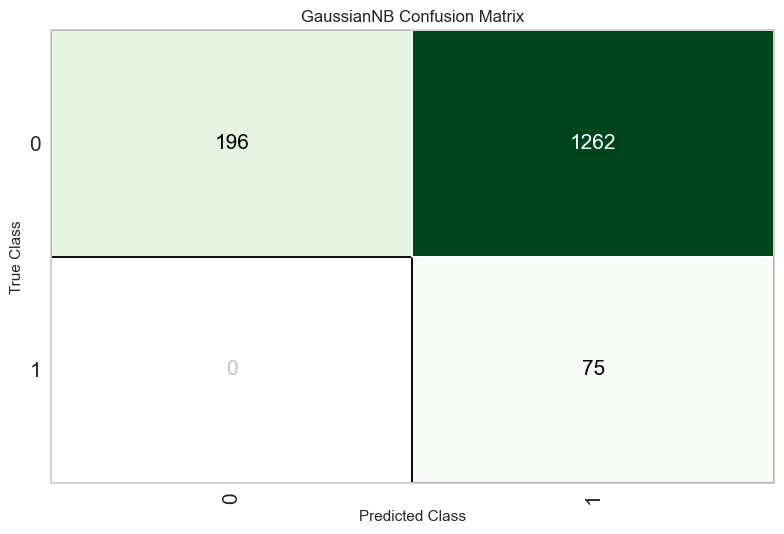

In [79]:
# plotting confusion matrix
exp.plot_model(recall, plot = 'confusion_matrix')

Confusion matrix is poor as well as accuracy. 
Let's try the model with the highest precision.

In [81]:
# extracting model with highest precision
precision = exp.compare_models(sort='Precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9486,0.8067,0.0343,0.3500,0.0607,0.0506,0.0919,0.1280
lightgbm,Light Gradient Boosting Machine,0.9480,0.8199,0.0461,0.2810,0.0779,0.0660,0.0971,1.1100
lda,Linear Discriminant Analysis,0.9438,0.8346,0.0794,0.1933,0.1109,0.0914,0.1001,0.0280
knn,K Neighbors Classifier,0.9477,0.6459,0.0284,0.1667,0.0482,0.0377,0.0527,0.1080
dt,Decision Tree Classifier,0.9047,0.5570,0.1719,0.1352,0.1503,0.1011,0.1022,0.0460
lr,Logistic Regression,0.9511,0.8404,0.0056,0.1000,0.0105,0.0090,0.0206,0.0320
et,Extra Trees Classifier,0.9480,0.7666,0.0114,0.0700,0.0191,0.0116,0.0160,0.2250
catboost,CatBoost Classifier,0.9483,0.8132,0.0118,0.0643,0.0189,0.0122,0.0158,3.2220
nb,Naive Bayes,0.2002,0.8093,0.9882,0.0568,0.1075,0.0171,0.0883,0.0280
gbc,Gradient Boosting Classifier,0.9463,0.8264,0.0056,0.0500,0.0100,0.0005,0.0033,0.3020


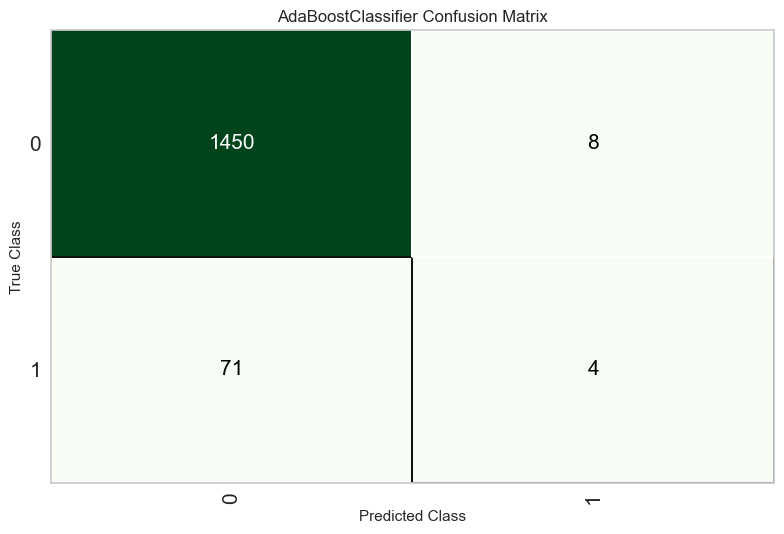

In [82]:
# plotting confusion matrix
exp.plot_model(precision, plot = 'confusion_matrix')

Better results, but still not a very high precision score to be satisfied.

It looks like there is no secret model hiding from our sight and that this is potentially an issue with our data.

In [85]:
# Remove all variables from storage
%store -z